In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import STL

from src.load_data import load_oil_price_data

import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [210]:
data = load_oil_price_data('2015-10-12')

In [211]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2015-10-12 00:00:00-04:00,127.919998,127.919998,121.599998,122.480003,3620138,0.0,0.0,0.0
2015-10-13 00:00:00-04:00,121.440002,124.959999,119.919998,120.480003,3733813,0.0,0.0,0.0
2015-10-14 00:00:00-04:00,119.839996,121.279999,118.800003,120.400002,2345463,0.0,0.0,0.0
2015-10-15 00:00:00-04:00,118.480003,121.120003,117.040001,121.040001,4521075,0.0,0.0,0.0
2015-10-16 00:00:00-04:00,122.239998,122.559998,119.279999,121.760002,2893050,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-10-16 00:00:00-04:00,78.629997,78.889999,77.870003,78.389999,5156200,0.0,0.0,0.0
2023-10-17 00:00:00-04:00,77.980003,78.879997,77.400002,78.800003,3914400,0.0,0.0,0.0
2023-10-18 00:00:00-04:00,79.720001,80.360001,79.320000,79.839996,4647300,0.0,0.0,0.0


## Data Preprocessing

In [212]:
def detrend_with_seasonality(series, period):
    stl_decomp = STL(series, period=period)
    result = stl_decomp.fit()
    detrended_series = series - result.trend
    return detrended_series, result.trend

In [213]:
detrended_series, trend = detrend_with_seasonality(data['Close'], period=52)

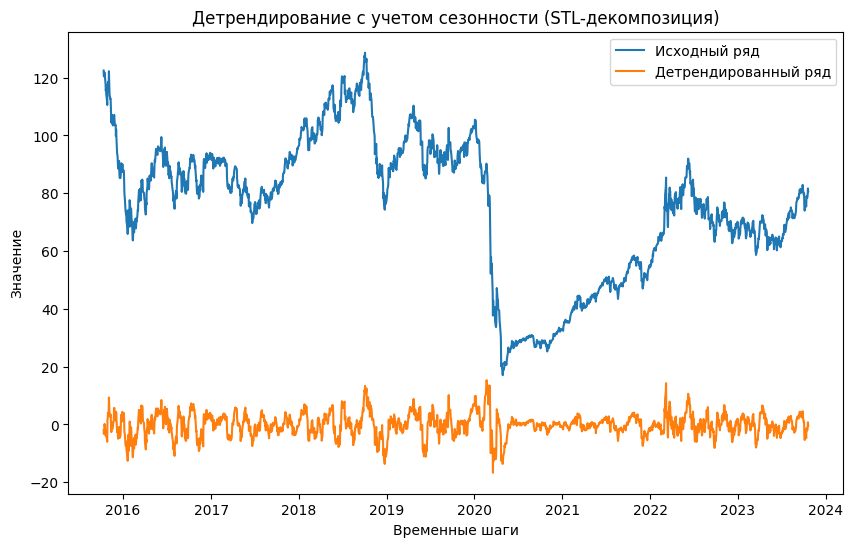

In [214]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Исходный ряд')
plt.plot(detrended_series, label='Детрендированный ряд')
plt.legend()
plt.xlabel('Временные шаги')
plt.ylabel('Значение')
plt.title('Детрендирование с учетом сезонности (STL-декомпозиция)')
plt.show() 

## Feature Engineering

In [215]:
lags = range(365)
features = ['mean', 'median', 'std', 'min', 'max']
X = pd.DataFrame(data['Close'])

In [216]:
for lag in lags:
    X[f'lag_{lag}'] = detrended_series.shift(lag)

for i in range(5, 100, 5):
    for feature in features:
        if feature == 'mean':
            X[f'{feature}_{i}'] = detrended_series.rolling(window=i).mean()
        elif feature == 'median':
            X[f'{feature}_{i}'] = detrended_series.rolling(window=i).median()
        elif feature == 'std':
            X[f'{feature}_{i}'] = detrended_series.rolling(window=i).std()
        elif feature == 'min':
            X[f'{feature}_{i}'] = detrended_series.rolling(window=i).min()
        elif feature == 'max':
            X[f'{feature}_{i}'] = detrended_series.rolling(window=i).max()

X['diff_1'] = detrended_series.diff(1)
X['diff_2'] = detrended_series.diff(2)
X['seasonal'] = data['Close'] - detrended_series

In [217]:
X = X.fillna(0)
y = X.Close

In [218]:
X = X.drop(['Close'], axis=1)

In [219]:
X

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,min_90,max_90,mean_95,median_95,std_95,min_95,max_95,diff_1,diff_2,seasonal
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-12 00:00:00-04:00,-1.994116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,124.474119
2015-10-13 00:00:00-04:00,-3.275932,-1.994116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.281817,0.000000,123.755936
2015-10-14 00:00:00-04:00,-2.637069,-3.275932,-1.994116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.638863,-0.642953,123.037070
2015-10-15 00:00:00-04:00,-1.277533,-2.637069,-3.275932,-1.994116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.359536,1.998399,122.317534
2015-10-16 00:00:00-04:00,0.162657,-1.277533,-2.637069,-3.275932,-1.994116,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.440190,2.799726,121.597345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-16 00:00:00-04:00,-2.073773,-1.316396,-4.728084,-4.318825,-3.118609,-2.537435,-5.345295,-5.352213,-3.588186,0.916768,...,-5.352213,4.555347,-0.250102,-0.495789,2.515189,-5.352213,4.555347,-0.757377,2.654312,80.463772
2023-10-17 00:00:00-04:00,-1.820231,-2.073773,-1.316396,-4.728084,-4.318825,-3.118609,-2.537435,-5.345295,-5.352213,-3.588186,...,-5.352213,4.555347,-0.247507,-0.495789,2.513421,-5.352213,4.555347,0.253542,-0.503835,80.620234
2023-10-18 00:00:00-04:00,-0.935803,-1.820231,-2.073773,-1.316396,-4.728084,-4.318825,-3.118609,-2.537435,-5.345295,-5.352213,...,-5.352213,4.555347,-0.252318,-0.589639,2.514305,-5.352213,4.555347,0.884428,1.137970,80.775799


In [220]:
y

Date
2015-10-12 00:00:00-04:00    122.480003
2015-10-13 00:00:00-04:00    120.480003
2015-10-14 00:00:00-04:00    120.400002
2015-10-15 00:00:00-04:00    121.040001
2015-10-16 00:00:00-04:00    121.760002
                                ...    
2023-10-16 00:00:00-04:00     78.389999
2023-10-17 00:00:00-04:00     78.800003
2023-10-18 00:00:00-04:00     79.839996
2023-10-19 00:00:00-04:00     81.680000
2023-10-20 00:00:00-04:00     80.699997
Name: Close, Length: 2021, dtype: float64

## Model

In [221]:
# Параметры модели
learning_rate = 0.01
n_estimators = 500
max_depth = 5

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [223]:
model = CatBoostRegressor(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)

In [224]:
model.fit(X_train, y_train)

0:	learn: 26.7088305	total: 18.1ms	remaining: 9.06s
1:	learn: 26.4990176	total: 29.7ms	remaining: 7.4s
2:	learn: 26.2917984	total: 41.7ms	remaining: 6.9s
3:	learn: 26.0912932	total: 54.3ms	remaining: 6.73s
4:	learn: 25.8869243	total: 66.5ms	remaining: 6.58s
5:	learn: 25.6928036	total: 89.1ms	remaining: 7.34s
6:	learn: 25.4738622	total: 124ms	remaining: 8.72s
7:	learn: 25.2762684	total: 138ms	remaining: 8.48s
8:	learn: 25.0633046	total: 150ms	remaining: 8.21s
9:	learn: 24.8776611	total: 182ms	remaining: 8.92s
10:	learn: 24.6678854	total: 204ms	remaining: 9.06s
11:	learn: 24.4826769	total: 216ms	remaining: 8.79s
12:	learn: 24.3039624	total: 229ms	remaining: 8.57s
13:	learn: 24.1194890	total: 241ms	remaining: 8.36s
14:	learn: 23.9162657	total: 253ms	remaining: 8.18s
15:	learn: 23.7363617	total: 267ms	remaining: 8.08s
16:	learn: 23.5499952	total: 281ms	remaining: 7.97s
17:	learn: 23.3565708	total: 294ms	remaining: 7.87s
18:	learn: 23.1568115	total: 306ms	remaining: 7.74s
19:	learn: 22.9661

In [225]:
y_pred = model.predict(X_test)

In [226]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2:", r2)

Mean Squared Error: 4.1301971745338575
R2: 0.9035516582855856


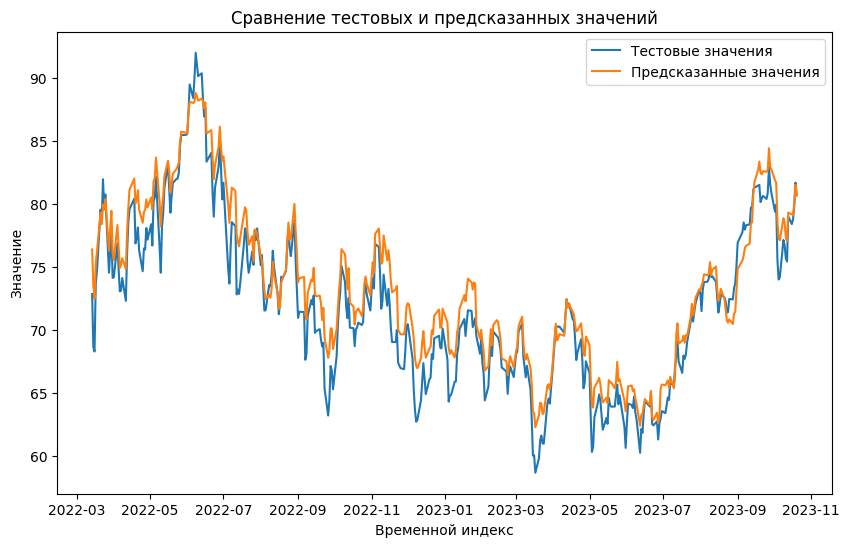

In [227]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Тестовые значения')
plt.plot(y_test.index, y_pred, label='Предсказанные значения')
plt.xlabel('Временной индекс')
plt.ylabel('Значение')
plt.title('Сравнение тестовых и предсказанных значений')
plt.legend()
plt.show()


In [228]:
predicted_values_with_trend = y_pred + trend[-len(y_pred):]

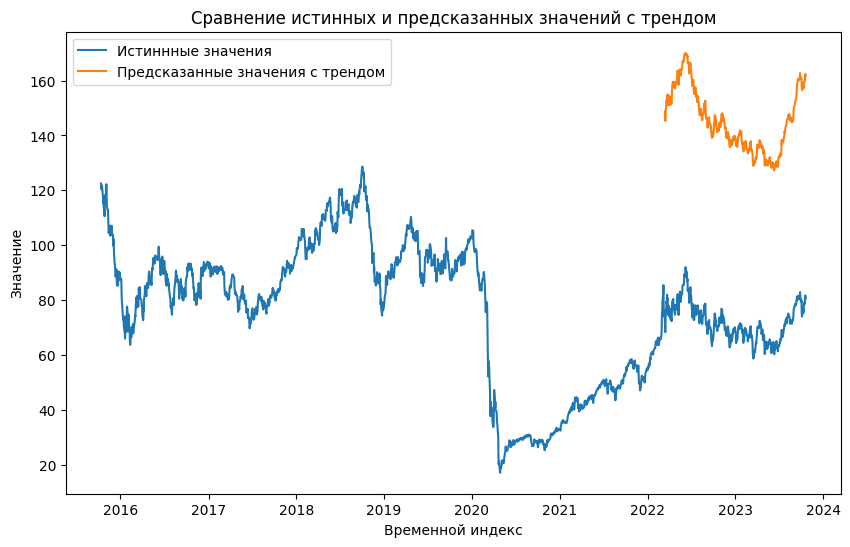

In [229]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data.Close, label='Истиннные значения')
plt.plot(predicted_values_with_trend.index, predicted_values_with_trend, label='Предсказанные значения с трендом')
plt.xlabel('Временной индекс')
plt.ylabel('Значение')
plt.title('Сравнение истинных и предсказанных значений с трендом')
plt.legend()
plt.show()